# Simulate long-range migration edge 

As an initial attempt, I will just add a **single** long range migration edge to a specific internal node **on top** of the original triangular lattice from before. I can envision using a greedy approach to fitting this likelihood function by adding a penalty term for which two nodes gets this edge...

Here, I will test the output of the function as I am developing it (code adapted from `sandbox.ipynb`)

## Changes to original code base:
1. adding function `setup_graph_long_range` in `sim.py`

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv
from feems.helper_funcs import plot_default_vs_long_range, comp_genetic_vs_fitted_distance, plot_estimated_vs_simulated_edges

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

## Testing function + visualization
*Note: nodes are numbered left-right, bottom-top by default in `networkx`*

In [2]:
# creating the basic skeletal graph used as default in feems
graph_def, _, _, edge_def = setup_graph(n_rows=4, n_columns=8, barrier_startpt=2.5, barrier_endpt=5.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

In [3]:
lrn = [(15,20)]
## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[2.0])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 500
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 900
Simulating ~SNP 950


In [11]:
%%time
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

CPU times: user 84.2 ms, sys: 7.72 ms, total: 91.9 ms
Wall time: 86.5 ms


In [22]:
sp_Graph_def.add_edge(*(0,12))
sp_Graph_def.fit_null_model()
#sp_Graph_def.fit(lamb=100.0, w_init=np.ones(len(sp_Graph_def.edges)), s2_init=1.0)

ValueError: row, column, and data array must all be the same length

In [21]:
sp_Graph_def.L_block

AttributeError: 'SpatialGraph' object has no attribute 'L_block'

constant-w/variance fit, converged in 126 iterations, train_loss=3619.8165824
lambda=10.0000000, alpha=0.6523658, converged in 12 iterations, train_loss=3431.7097134
constant-w/variance fit, converged in 126 iterations, train_loss=3619.8165824
lambda=10.0000000, alpha=0.6523658, converged in 12 iterations, train_loss=3431.7097126
constant-w/variance fit, converged in 123 iterations, train_loss=3520.2073563
lambda=10.0000000, alpha=0.7154547, converged in 12 iterations, train_loss=3319.1489350
constant-w/variance fit, converged in 123 iterations, train_loss=3520.2073563
lambda=10.0000000, alpha=0.7154547, converged in 12 iterations, train_loss=3319.1489357


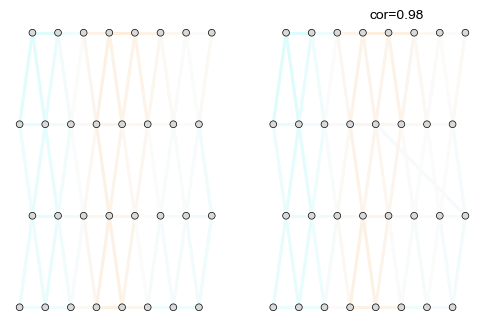

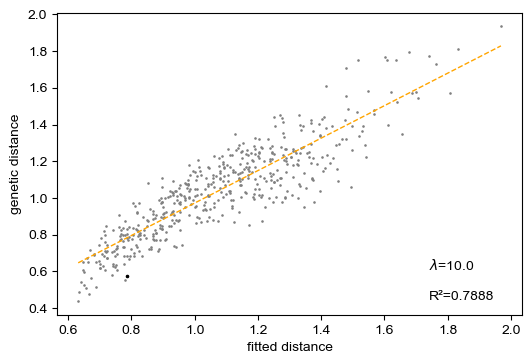

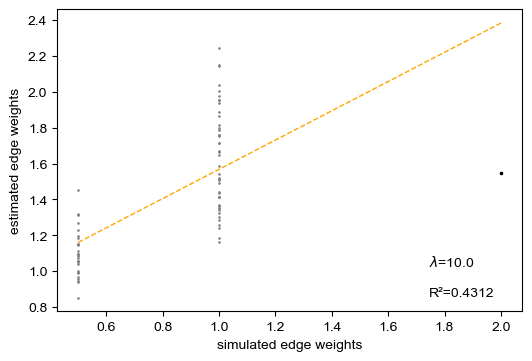

In [8]:
# obtaining pairs of nodes with maximum residuals (TOP 1)
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=1, lamb=10.0, plotFig=False)

# creating a new spatial graph with extra edge
gr = deepcopy(graph_def)
gr.add_edges_from(max_res_nodes)
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(gr.edges)+1)

# visualtization of feems fit
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes, lamb=10.0)

comp_genetic_vs_fitted_distance(sp_Graph, lrn, lamb=10.0, plotFig=True)

plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn, max_res_nodes, lamb=10.0)

In [9]:
print(sp_Graph_def.nll)
sp_Graph.nll

3619.816582350659


3520.2073563319136

## Default `feems` fit  

In [5]:
# %%time
# sp_Graph.fit_null_model()
sp_Graph_def.fit(lamb = 10.0)
# obj = Objective(sp_Graph_def)
# obj._solve_lap_sys()
# obj._comp_mat_block_inv()
# obj._comp_inv_cov()
# obj.neg_log_lik()
# sp_Graph_def.nll

constant-w/variance fit, converged in 126 iterations, train_loss=3619.8165824
lambda=10.0000000, alpha=0.6523658, converged in 12 iterations, train_loss=3431.7097126


Surprisingly, it seems like the long range migration edge (0,12) is captured by the model! However, this could be because I set the long range migraton to be 2x more than corridor and 4x more than barrier migration rate. Below I use a root mean squared relative error to calculate deviation of estimated from simulated but weighted with respect to the estimated value
$$
\text{RMSRE} = \sqrt{1/n \sum_i \Big(\frac{X_i - T_i}{T_i}\Big)^2}
$$

In [ ]:
def rmsre_edge_weights(graph, sp_Graph):
    # simulated graph edges
    sim_edges = np.array([graph[val[0]][val[1]]["w"] for _, val in enumerate(list(graph.edges))])
    return np.sqrt(np.mean(((sp_Graph.w-sim_edges)/sp_Graph.w)**2))

### Further testing with varying parameters 

Now, I will try out the following parameter regimes: more disconnected long range edges, weaker long range migration, and multiple incoming long range edges to same node. The previous parameter regime had one long range edge between node 0 and 12 with migration rate of 1.0 (compared to 0.5 in the corridors and 0.1 in the barrier). 

#### 1. Varying number of long range edges

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 550
Simulating ~SNP 700
Simulating ~SNP 800
Simulating ~SNP 950


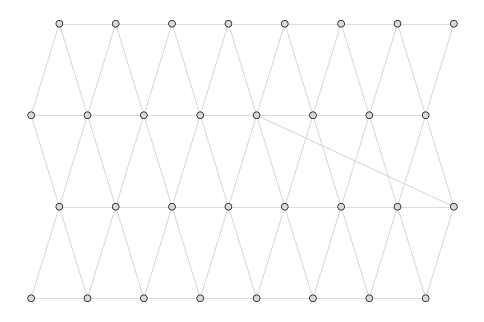

In [655]:
lrn = [(0,12),(15,20),(9,31)]
graph, coord, grid, edge = setup_graph_long_range(corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.0,1.0,1.0])
gen_test = simulate_genotypes(graph)

sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

# proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# # drawing the simulated graph 
# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(1, 1, 1)  
# v = Viz(ax, sp_Graph, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_samples()
# v.draw_edges(use_weights=False)
# v.draw_obs_nodes(use_ids=False)

constant-w/variance fit, converged in 125 iterations, train_loss=3608.3196592
lambda=10.0000000, alpha=0.6145220, converged in 12 iterations, train_loss=3477.7869685
constant-w/variance fit, converged in 125 iterations, train_loss=3608.3196592
lambda=10.0000000, alpha=0.6145220, converged in 13 iterations, train_loss=3477.7869640
constant-w/variance fit, converged in 129 iterations, train_loss=12991.6703327
lambda=10.0000000, alpha=1.2074736, converged in 12 iterations, train_loss=12350.4810710
constant-w/variance fit, converged in 129 iterations, train_loss=12991.6703327
lambda=10.0000000, alpha=1.2074736, converged in 12 iterations, train_loss=12350.4810720


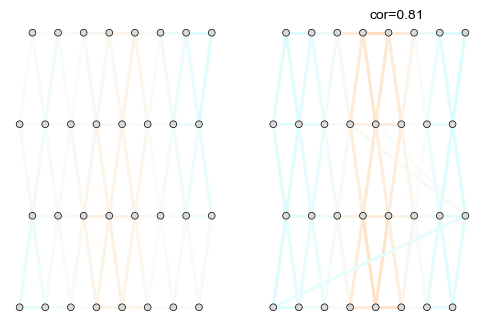

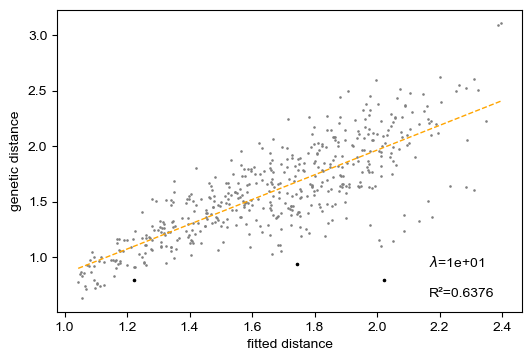

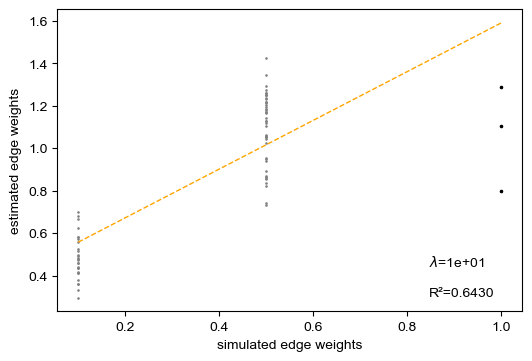

In [656]:
# obtaining pairs of nodes with maximum residuals (TOP 3)
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=3, lamb=10.0, plotFig=False)

# creating a new spatial graph with extra edge
gr = deepcopy(graph_def)
gr.add_edges_from(max_res_nodes)
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(gr.edges)+1)

# visualtization of feems fit
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes, lamb=10.0)

comp_genetic_vs_fitted_distance(sp_Graph, lrn, lamb=10.0, plotFig=True)

plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn, max_res_nodes, lamb=10.0)

The above result shows that `feems` does pretty well in finding multiple long range migration edges, even with somewhat similar migration rates to the corridors (2x, compared to 4x from before). 

#### 2. Weak migration (similar to corridor rates)

Based on the results from the analysis below, I still find that `feems` does well in capturing these long range migrations. 
<a id='weakmigration'></a>

Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 450
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


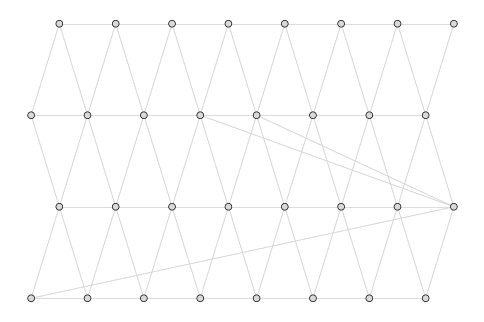

In [657]:
graph, coord, grid, edge = setup_graph_long_range(corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[0.5,0.5,0.5])
gen_test = simulate_genotypes(graph)

sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

constant-w/variance fit, converged in 125 iterations, train_loss=3608.3196592
lambda=10.0000000, alpha=0.6145220, converged in 12 iterations, train_loss=3477.7869685
constant-w/variance fit, converged in 125 iterations, train_loss=3608.3196592
lambda=10.0000000, alpha=0.6145220, converged in 13 iterations, train_loss=3477.7869640
constant-w/variance fit, converged in 126 iterations, train_loss=14549.2503813
lambda=10.0000000, alpha=1.4866525, converged in 11 iterations, train_loss=13693.0401405
constant-w/variance fit, converged in 126 iterations, train_loss=14549.2503813
lambda=10.0000000, alpha=1.4866525, converged in 13 iterations, train_loss=13693.0401170


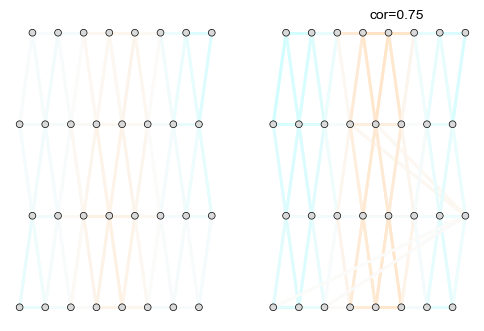

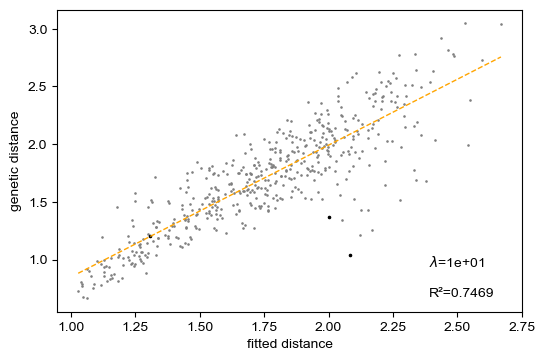

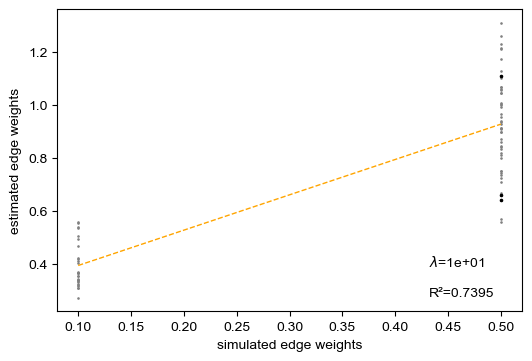

In [658]:
# obtaining pairs of nodes with maximum residuals (TOP 3)
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=5, lamb=10.0, plotFig=False)

# creating a new spatial graph with extra edges
gr = deepcopy(graph_def)
gr.add_edges_from(max_res_nodes)
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(gr.edges)+1)

# visualtization of feems fit
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes, lamb=10.0)

comp_genetic_vs_fitted_distance(sp_Graph, lrn, lamb=10.0, plotFig=True)

plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn, max_res_nodes, lamb=10.0)

#### 3. Multiple long range migration edges to same node

Based on the results below, `feems` works well to estimate these long range migration edges accurately, even with multiple edges to the same node. 

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 150
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 500
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 950


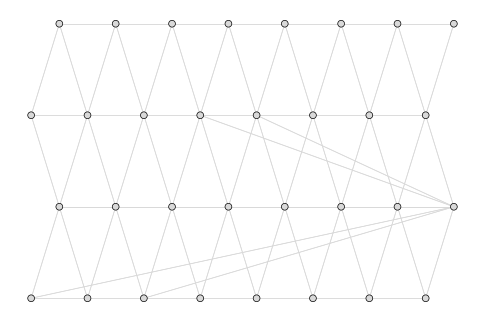

In [659]:
lrn = [(0,12),(12,31),(12,24)]
graph, coord, grid, edge = setup_graph_long_range(corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.0,1.0,1.0])
gen_test = simulate_genotypes(graph)

sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

constant-w/variance fit, converged in 125 iterations, train_loss=3608.3196592
lambda=10.0000000, alpha=0.6145220, converged in 12 iterations, train_loss=3477.7869685
constant-w/variance fit, converged in 125 iterations, train_loss=3608.3196592
lambda=10.0000000, alpha=0.6145220, converged in 13 iterations, train_loss=3477.7869640
constant-w/variance fit, converged in 136 iterations, train_loss=15007.3142309
lambda=10.0000000, alpha=1.2881967, converged in 13 iterations, train_loss=14096.9074591
constant-w/variance fit, converged in 136 iterations, train_loss=15007.3142309
lambda=10.0000000, alpha=1.2881967, converged in 13 iterations, train_loss=14096.9074558


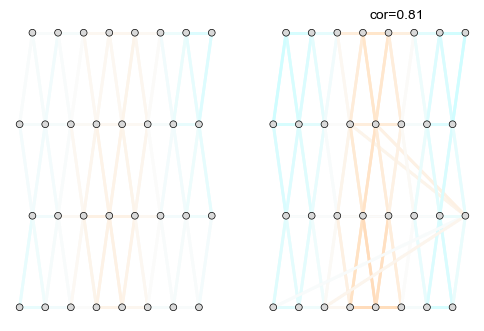

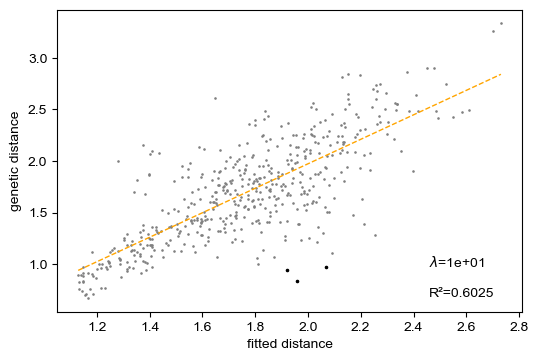

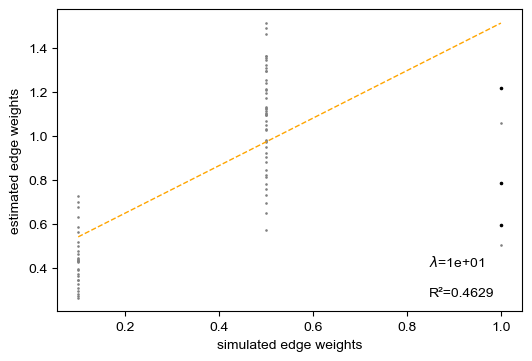

In [660]:
# obtaining pairs of nodes with maximum residuals (TOP 3)
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=5, lamb=10.0, plotFig=False)

# creating a new spatial graph with extra edges
graph_def.add_edges_from(max_res_nodes)
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(graph_def.edges)+1)

# visualtization of feems fit
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes, lamb=10.0)

comp_genetic_vs_fitted_distance(sp_Graph, lrn, lamb=10.0, plotFig=True)

plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn, max_res_nodes, lamb=10.0)

### Spoofing the model by giving it all possible edges

Here, I will simulate under the model in **3** (multiple long range edges to same node) above, but will provide the model with edges connecting every population to every other population as a way of seeing if the model can detect the edges with long range migration. 

In [ ]:
# constructing the graph object
## every combination of edge with same genotypes as before
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(list(it.combinations(np.arange(1,33),2))))

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

## Jun 30, 2021
### Methods 

First, I create a default `feems` spatial graph object with no long range edges called `sp_Graph_def`, this has attributes of `graph_def` and `edge_def`. 

Second, I simulate a certain scenario using `setup_graph_long_range` and store it in the `graph` object, for instance, multiple long range edges to the same node. Then, I use these objects to simulate genotypes under this scenario using `simulate_genotypes`. 

Third, I fit this graph using a certain $\lambda$ value, and examine the pairs of nodes in which the residual between genetic and fitted distance is the highest (top 3, top 5, etc.) 
I use these pairs of nodes to add extra edges to my new graph object `sp_Graph`, which has the same `coord` and `grid` as the default but with a new `edges` object. I fit this graph with the same $\lambda$ value and compare the results using the following three procedures:  
    a. `plot_default_vs_long_range` will plot the `feems` fit on the default graph and on the new graph with long range edges next to each other, with correlation of the estimated weights.   
    b. `comp_genetic_vs_fitted_distance(..., plotFig=True)` will plot the pairs of nodes on the genetic vs fitted distance axes with the selected maximal residual pairs highlighted in black.  
    c. `plot_estimated_vs_simulated_edges` will plot the estimated vs simulated migration rates and highlight the long range nodes in black to better visualize the quality of `feems` fit.  

### Main takeaways

1. Pretty high correlation (0.75 to 0.85) between weights in the graph with no long range edges and graph with long range edges, across a variety of simulation scenarios.  
2. If there are multiple nodes with long range edges, the algorithm using maximum residuals always picks one of the three (for example) simulated nodes and attaches multiple edges to it, instead of identifying each distinct long range edge.  
3. When the migration rates at long range edges are higher than elsewhere (2x of corridor and 4x of barrier) in the graph, they are always underestimated.   
4. When the migration rates at long range edges are similar to the corridor rates in the graph, they are on average estimated accurately.  
5. Choosing more maxmial residual edges than simulated leads to this pattern seen in point **2**, wherein, most edges connect to the same node and fan out to other nodes in the graph (most nodes in the same direction as the simulated long range effects).  

## Investigating the 'greedy' approach to fitting long range edges

First, I will see if the covariance of allele frequencies across nodes tells us something about which nodes could potentially have a long range migration. This seems promising, in that for node 0 is found to covary with node 12 the third-most (right after its neighboring nodes). 

In [ ]:
np.set_printoptions(threshold=np.inf)
np.argsort(sp_Graph.S[16,:],)
np.argsort(sp_Graph_def.S[22,:]-np.max(sp_Graph_def.S[22,:]))

In [ ]:
sp_Graph_def.Delta.toarray()[32,:]